In [65]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Predict Gene Expression Part II: Training and Evaluating the Model

This notebook uses duet evoC data to predict gene expression in mouse embryonic stem cells ES-E14. It uses methylation data in a set of genomic regions (upstream of the TSS, around TSS, gene body, first exon, first intron, exons, introns, 5 and 3' UTRs and downstream region with sense and strand information), and learns gene expression from it, using a [public dataset of expression](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135509). The regions are based on the Gencode annotations, for the mm10 mouse genome.

For each region, we compute a mean 5mC fraction, a mean 5hmC, and record the number of CpGs in the region (regardless of whether they are methylated or not), and the length of the region. This forms a basis of 4 features per region, times 6 regions, hence 24 features.

Note that the regions we selected may have an overlap (in particular promoter, around TSS, and gene body). A natural extension would be to add more regions, mostly all exons and introns (taking the mean across them), and divide the promoter and downstream regions in sub-regions.

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns

In [67]:
from scipy.stats import spearmanr
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
    f1_score,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [68]:
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)
column_order = [
    'before_tss', 'after_tes', 'five_prime_utrs', 'first_exons', 'first_introns', 
    'exons', 'introns', 'three_prime_utrs', 'genes',
    ]

### Load features from pickle file

In [69]:
df_features = pd.read_pickle("rerun_CEGXRun1485.pickle")

### Load Gene Expression

load selected transcripts

In [70]:
from modality.annotation import get_transcripts

def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]


# Get transcripts for mm10
transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )

selected_transcripts = transcripts.groupby('gene_id').apply(
    select_transcript_based_on_tag
    ).reset_index(drop=True)
selected_transcripts.head()

gene_id          transcript_id
0   ENSMUSG00000000001.4   ENSMUST00000000001.4
1  ENSMUSG00000000003.15  ENSMUST00000000003.13
2  ENSMUSG00000000028.15  ENSMUST00000000028.13
3  ENSMUSG00000000037.17   ENSMUST00000101113.8
4  ENSMUSG00000000049.11   ENSMUST00000000049.5

In [71]:
# def rpm_to_rpkm(rpm, length):
#     """
#     Convert RPM to RPKM
#     """
#     return rpm - np.log2(length) + np.log2(1e3)

# ge_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# # ge_path = "../data/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# df_expression = pd.read_csv(ge_path, sep="\t")
# df_expression.head()

In [72]:
# def load_rna_expression(convert_to_rpkm=True):
#     rna_data_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
#     df_expression = pd.read_csv(rna_data_path, sep="\t")

#     # revert from log2(RPM) to RPM before taking the mean
#     df_expression["E14_rep_1"] = np.power(2, df_expression["E14_rep_1 (log2 RPM)"])
#     df_expression["E14_rep_2"] = np.power(2, df_expression["E14_rep_2 (log2 RPM)"])
#     df_expression["E14_rep_3"] = np.power(2, df_expression["E14_rep_3 (log2 RPM)"])

#     # take the mean of the three replicates
#     df_expression["E14_expr"] = np.mean(
#         df_expression[["E14_rep_1", "E14_rep_2", "E14_rep_3"]],
#         axis=1,
#     )

#     # log2 transform
#     df_expression["Response"] = np.log2(df_expression["E14_expr"])

#     # convert to RPKM
#     if convert_to_rpkm:
#         df_expression["Gene_length"] = df_expression["End"] - df_expression["Start"]
#         df_expression["Response"] = rpm_to_rpkm(
#             df_expression["Response"], df_expression["Gene_length"]
#         )

#     # Convert to 0-based
#     df_expression["Start"] = df_expression["Start"] - 1
#     df_expression["End"] = df_expression["End"] - 1

#     return df_expression

In [73]:
df_features

Gene_id Chromosome     Start       End Gene_name contig  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1      1   
...                      ...        ...       ...       ...       ...    ...   
43209   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394      Y   
43210   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
43211   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
43212   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   
43213   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   

      strand  mean_mc_before_tss_sense  mean_mc_after_tes_sense  \
0          +                  0.000000                 0.000000   
1          -                       NaN                      NaN   
2          +                  0.000689                 0.000689   
3          -                       NaN                      NaN   
4          +                  0.001969                 0.001969   
...      ...                       ...                      ...   
43209      -                       NaN                      NaN   
43210      +                       NaN                      NaN   
43211      -                       NaN                      NaN   
43212      +                       NaN                      NaN   
43213      -                  0.800000                 0.800000   

       mean_mc_genes_sense  ...  range_length_before_tss_sense  \
0                 0.529368  ...                          200.0   
1                 0.538405  ...                            NaN   
2                 0.472305  ...                          200.0   
3                 0.483284  ...                            NaN   
4                 0.514725  ...                          200.0   
...                    ...  ...                            ...   
43209             0.683544  ...                          200.0   
43210             0.606061  ...                            NaN   
43211             0.642857  ...                          200.0   
43212             0.734607  ...                            NaN   
43213             0.773050  ...                          200.0   

       range_length_after_tes_sense  range_length_genes_sense  \
0                             200.0                   40622.0   
1                               NaN                   40622.0   
2                             200.0                   78878.0   
3                               NaN                   78878.0   
4                             200.0                   40095.0   
...                             ...                       ...   
43209                         200.0                    2335.0   
43210                           NaN                    2391.0   
43211                         200.0                    2391.0   
43212                           NaN                   32108.0   
43213                         200.0                   32108.0   

       range_length_first_exons_sense  range_length_first_introns_sense  \
0                               159.0                              35.0   
1                                 NaN                               NaN   
2                                90.0                           20602.0   
3                                 NaN                               NaN   
4                               162.0                            9494.0   
...                               ...                               ...   
43209                           118.0                            1114.0   
43210                             NaN                               NaN   
43211 

In [74]:
def load_rna_expression(features, selected_transcripts, transcripts):
    ge_path = "../data/quant.sf"
    df_expression = pd.read_csv(ge_path, sep="\t")
    print(df_expression.shape)

    full_selected_transcript = pd.merge(selected_transcripts,transcripts, left_on='transcript_id', right_on='id', how='left')

    # Merge df_expression with transcripts on the matching columns
    merged_df = pd.merge(full_selected_transcript[['id', 'parent', 'strand']], df_expression, left_on='id', right_on='Name', how='left')
    merged_df = pd.merge(merged_df, features[['Gene_id','contig']], left_on='parent', right_on='Gene_id', how='left')

    # Add the 'gene_id' column to df_expression
    df_expression['Gene_id'] = merged_df['parent']
    df_expression['strand'] = merged_df['strand']
    df_expression['contig'] = merged_df['contig']
    df_expression_clean = df_expression[~df_expression.isna().any(axis=1)]
    df_expression_clean

    return df_expression_clean

df_expression = load_rna_expression(df_features, selected_transcripts, transcripts)
df_expression.head()

(142699, 5)


Name  Length  EffectiveLength       TPM  NumReads  \
0  ENSMUST00000193812.1    1070          884.760  0.000000       0.0   
1  ENSMUST00000082908.1     110           10.723  0.000000       0.0   
2  ENSMUST00000162897.1    4153         3967.760  0.000000       0.0   
3  ENSMUST00000159265.1    2989         2803.760  0.088163       2.0   
4  ENSMUST00000070533.4    3634         3448.760  0.000000       0.0   

                 Gene_id strand contig  
0   ENSMUSG00000000001.4      -      3  
1   ENSMUSG00000000001.4      -      3  
2  ENSMUSG00000000003.15      -      X  
3  ENSMUSG00000000003.15      -      X  
4  ENSMUSG00000000028.15      -     16

In [75]:
df_features_expression = pd.merge(
    df_features,
    df_expression,
    on=["Gene_id", "contig", "strand"],
    how="inner",
)

In [76]:
df_features_expression

Gene_id Chromosome     Start       End Gene_name contig  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1      1   
...                      ...        ...       ...       ...       ...    ...   
43077   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394      Y   
43078   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
43079   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
43080   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   
43081   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   

      strand  mean_mc_before_tss_sense  mean_mc_after_tes_sense  \
0          +                  0.000000                 0.000000   
1          +                  0.000000                 0.000000   
2          +                  0.000689                 0.000689   
3          +                  0.000689                 0.000689   
4          +                  0.001969                 0.001969   
...      ...                       ...                      ...   
43077      -                       NaN                      NaN   
43078      -                       NaN                      NaN   
43079      -                       NaN                      NaN   
43080      -                  0.800000                 0.800000   
43081      -                  0.800000                 0.800000   

       mean_mc_genes_sense  ...  range_length_exons_sense  \
0                 0.529368  ...                    4678.0   
1                 0.529368  ...                    4678.0   
2                 0.472305  ...                    1450.0   
3                 0.472305  ...                    1450.0   
4                 0.514725  ...                    4750.0   
...                    ...  ...                       ...   
43077             0.683544  ...                    2206.0   
43078             0.642857  ...                    2202.0   
43079             0.642857  ...                    2202.0   
43080             0.773050  ...                    1756.0   
43081             0.773050  ...                    1756.0   

       range_length_introns_sense  range_length_five_prime_utrs_sense  \
0                         76178.0                               180.0   
1                         76178.0                               180.0   
2                        114922.0                                 NaN   
3                        114922.0                                 NaN   
4                         56128.0                               198.0   
...                           ...                                 ...   
43077                         NaN                               796.0   
43078                        12.0                                 NaN   
43079                        12.0                                 NaN   
43080                     59646.0                               112.0   
43081                     59646.0                               112.0   

       range_length_three_prime_utrs_sense  selected_transcript  \
0                                   3444.0                 True   
1                                   3444.0                 True   
2                                      NaN                 True   
3                                      NaN                 True   
4                                   3080.0                 True   
...                                    ...                  ...   
43077                                276.0                 True   
43078                                  NaN                 True   
43079                                  NaN

remove empty columns

In [77]:
nan_columns = df_features_expression.isna().all()
print(nan_columns[nan_columns].index)  # Columns with all NaN values

df_features_expression_clean = df_features_expression.dropna(axis=1, how='all')
df_features_expression_clean = df_features_expression_clean.drop('contig', axis=1)


Index(['mean_mc_before_tss_antisense', 'mean_mc_after_tes_antisense',
       'mean_mc_first_exons_antisense', 'mean_mc_first_introns_antisense',
       'mean_mc_exons_antisense', 'mean_mc_introns_antisense',
       'mean_mc_five_prime_utrs_antisense',
       'mean_mc_three_prime_utrs_antisense', 'mean_hmc_before_tss_antisense',
       'mean_hmc_after_tes_antisense', 'mean_hmc_first_exons_antisense',
       'mean_hmc_first_introns_antisense', 'mean_hmc_exons_antisense',
       'mean_hmc_introns_antisense', 'mean_hmc_five_prime_utrs_antisense',
       'mean_hmc_three_prime_utrs_antisense', 'mean_modc_before_tss_antisense',
       'mean_modc_after_tes_antisense', 'mean_modc_first_exons_antisense',
       'mean_modc_first_introns_antisense', 'mean_modc_exons_antisense',
       'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense',
       'mean_modc_three_prime_utrs_antisense'],
      dtype='object')


In [78]:
df_features_expression_clean.shape

(43082, 60)

In [79]:
df_features_expression_clean.columns

Index(['Gene_id', 'Chromosome', 'Start', 'End', 'Gene_name', 'strand',
       'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense',
       'mean_mc_genes_sense', 'mean_mc_first_exons_sense',
       'mean_mc_first_introns_sense', 'mean_mc_genes_antisense',
       'mean_mc_exons_sense', 'mean_mc_introns_sense',
       'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense',
       'mean_hmc_before_tss_sense', 'mean_hmc_after_tes_sense',
       'mean_hmc_genes_sense', 'mean_hmc_first_exons_sense',
       'mean_hmc_first_introns_sense', 'mean_hmc_genes_antisense',
       'mean_hmc_exons_sense', 'mean_hmc_introns_sense',
       'mean_hmc_five_prime_utrs_sense', 'mean_hmc_three_prime_utrs_sense',
       'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense',
       'mean_modc_genes_sense', 'mean_modc_first_exons_sense',
       'mean_modc_first_introns_sense', 'mean_modc_genes_antisense',
       'mean_modc_exons_sense', 'mean_modc_introns_sense',
       'mean_modc_five_prime_utr

Let's have a look at the data:

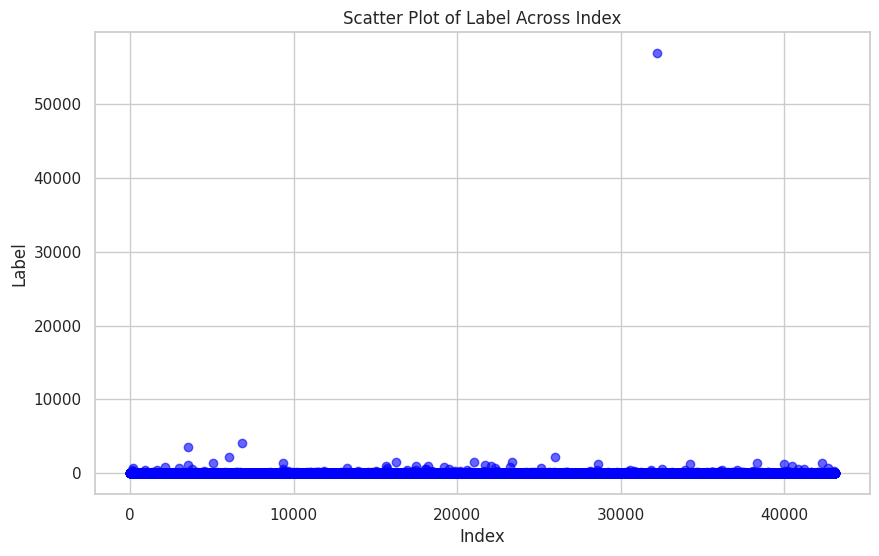

In [80]:
def plot_target(df, target):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[target], color='blue', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('Label')
    plt.title('Scatter Plot of Label Across Index')
    plt.show()
plot_target(df_features_expression_clean, "TPM")

remove the outlier using z-score

number of entries removed: 23 (out of 43082)


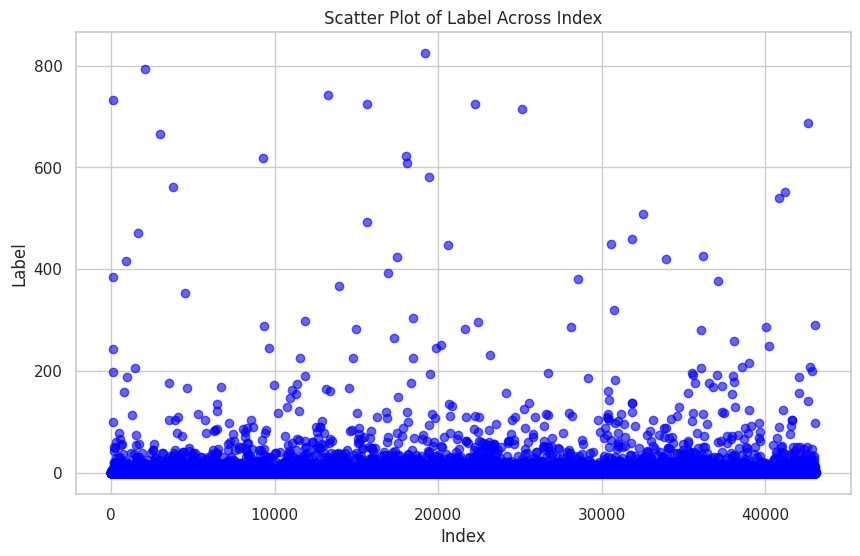

In [81]:
from scipy import stats
# Calculate Z-scores
z_scores = np.abs(stats.zscore(df_features_expression_clean['TPM']))
# Define threshold for outliers
threshold = 3
# Filter out outliers
print(f"number of entries removed: {df_features_expression_clean[(z_scores >= threshold)].shape[0]} (out of {df_features_expression_clean.shape[0]})")
df_clean = df_features_expression_clean[(z_scores < threshold)]
plot_target(df_clean, "TPM")

## Run regressor to predict gene expression

We use [XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html) to train a regression model to predict RPKM gene expression values. The hyperparameters were selected from a grid search.

We split the implementation into several functions which take care of imputing missing data, split the data into testing and training, doing a grid search of hyperparameters if requested, training the model, evaluating the model, and plotting the model versus observations.

By default, we impute the mean of a feature where there is a NaN. NaNs could appear because of lack of coverage in this region. We decided on imputing a mean instead of a 0 as to not conflate the actual 0's in the features, which correspond to regions containing no methylation.

We split our data between training and testing using a leave-one-out strategy over all chromosomes. By default we use 10% of each chromosome as the test genes, and the rest of the genome for training.

In [82]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

def impute_multimodal(data_train, data_test, columns_to_keep, missing_values_strategy="mean"):
    print(f"inside impute -- train: {data_train.shape}, test: {data_test.shape}")

    # Subset the columns to be used
    train_subset = data_train[columns_to_keep].copy()
    test_subset = data_test[columns_to_keep].copy()

    print(f"subsets: {data_train.shape}, {data_test.shape}")

    # Apply KMeans clustering on the training data (on non-missing values)
    kmeans = KMeans(n_clusters=2, random_state=42)
    non_missing_train = train_subset.dropna()
    kmeans.fit(non_missing_train)
    # Predict clusters for the training data
    train_subset['cluster'] = kmeans.predict(train_subset.fillna(0))

    # Assign clusters to the test data based on the fitted model
    test_subset['cluster'] = kmeans.predict(test_subset.fillna(0))  # Avoid issues by filling NaNs temporarily

    print("initialised clusters")
     # Impute within each cluster for the training set
    for cluster in range(kmeans.n_clusters):
        # Train set: select rows that belong to the current cluster
        cluster_train_data = train_subset[train_subset['cluster'] == cluster]
        
        # Impute missing values for the current cluster in the training set
        imputer = SimpleImputer(strategy=missing_values_strategy)
        imputed_train = imputer.fit_transform(cluster_train_data.drop(columns='cluster'))
        train_subset.loc[train_subset['cluster'] == cluster, columns_to_keep] = imputed_train

    # Impute within each cluster for the test set
    for cluster in range(kmeans.n_clusters):
        # Test set: select rows that belong to the current cluster
        cluster_test_data = test_subset[test_subset['cluster'] == cluster]
        
        # Use the same imputer fitted on the train cluster to impute test set
        imputed_test = imputer.transform(cluster_test_data.drop(columns='cluster'))
        test_subset.loc[test_subset['cluster'] == cluster, columns_to_keep] = imputed_test

    # Drop the 'cluster' column after imputation
    train_subset = train_subset.drop(columns='cluster')
    test_subset = test_subset.drop(columns='cluster')

    # Update the original data
    data_train[columns_to_keep] = train_subset
    data_test[columns_to_keep] = test_subset

    return data_train, data_test


In [83]:
def impute_missing_values(
        data_train, 
        data_test, 
        columns_to_keep, 
        missing_values_strategy="impute_mean",
        ):
    """
    Impute missing values in a dataframe
    """
    data_train = data_train.copy()
    data_test = data_test.copy()
    if missing_values_strategy == "drop":
        data_train[columns_to_keep] = data_train[columns_to_keep].dropna()
        data_test[columns_to_keep] = data_test[columns_to_keep].dropna()
    elif missing_values_strategy == "impute_zero":
        data_train[columns_to_keep] = data_train[columns_to_keep].fillna(0)
        data_test[columns_to_keep] = data_test[columns_to_keep].fillna(0)
    elif missing_values_strategy == "impute_mean":
        imputer = SimpleImputer(strategy="mean")
        data_train_subset = imputer.fit_transform(data_train[columns_to_keep])
        data_test_subset = imputer.transform(data_test[columns_to_keep])
        # Reassign the imputed columns back into the original dataframes if needed
        print(f"train subset created: {data_train_subset.shape}")
        print(f"subset created:{data_test_subset.shape}")
        data_train[columns_to_keep] = data_train_subset
        data_test[columns_to_keep] = data_test_subset
    return data_train, data_test

In [84]:
def select_features(features, mod):
    """
    Select features based on the modification type. Only keep the features corresponding to the list `mod`. 
    E.g. if mod="modc", only keep features related to modC, and discard those related to mC and hmC
    """
    if isinstance(mod, str):
        mod = [mod]
    return [f for f in features if any([m in f for m in mod]) or "cpg_count" in f or "range" or "strand" in f]

1. group data by chromosome
2. loop through each group, shuffle subset
3. train test split each subset with 0.1 test size, cache index of test indices identified
4. allocate test_set with collated indices
5. drop test_set indices from orginal dataset, forming train_set

In [85]:
from sklearn.model_selection import train_test_split
def stratified_sampling_per_contig(df, target, test_size=0.1):
    test_indices = []

    # Group by contig
    grouped = df.groupby('Chromosome')
    
    for contig, group in grouped:
        # Split the group into train and test
        # group = group.sample(frac=1, random_state=42).reset_index(drop=False)
        
        train, test = train_test_split(
            group,
            #stratify=group[target],
            test_size=test_size,
            random_state=42
        )
        
        test_indices.extend(test.index)
    
    test_set = df.loc[test_indices]
    train_set = df.drop(test_indices)
    print(f"trainset: {train_set.shape}")
    print(f"testset: {test_set.shape}")
    return train_set, test_set

In [86]:
def split_train_test_data(data, features, target, test_contig=None, missing_values_strategy="impute_mean"):
    """
    Split the data into training and testing sets using the specified test contig
    """
    print("inside train test split")
    if isinstance(test_contig, str):
        test_contig = [test_contig]
    # data_train = data[~data["Chromosome"].isin(test_contig)]
    # data_test = data[data["Chromosome"].isin(test_contig)]
    data_train , data_test = stratified_sampling_per_contig(data, target) #TODO:need to bin target to stratify

    # Check the distribution of TPM in the test set
    print(data_test[target].value_counts()/len(data))
    print('-'*50)
    # Check the distribution of contigs in the test set
    print(data_test['Chromosome'].value_counts()/data['Chromosome'].value_counts())
    print('-'*50)

    print("before imputing")

    # Assuming 'features' is your list of feature names
    impute_features = [f for f in features if not f.startswith("strand")]

    data_train, data_test = impute_multimodal(
        data_train,
        data_test,
        impute_features + [target],
        "mean"
    )
    # data_train, data_test = impute_missing_values(
    #     data_train, 
    #     data_test, 
    #     impute_features + [target], 
    #     missing_values_strategy
    #     )
    X_train, y_train = data_train[features], data_train[target]
    X_test, y_test = data_test[features], data_test[target]
    return X_train, X_test, y_train, y_test


In [87]:
def tune_parameters(X_train, y_train):
    """
    Identify the best hyperparameters of the XGBoost regressor using GridSearchCV
    """
    param_grid = {
        "max_depth": [5, 6, 7],
        "n_estimators": [600, 800, 1000], #[200, 300, 400, 500, 600, 700, 800],
        "subsample": [0.6, 0.7, 0.8],
        "min_child_weight": [1, 5, 10],
        "colsample_bytree": [0.8, 0.9],#[0.75, 0.8, 0.85, 0.9],
        "eta": [0.01, 0.02, 0.03]#[0.01, 0.02, 0.03, 0.04, 0.05],
    }
    regressor = xgb.XGBRegressor(eval_metric="rmsle")
    search = GridSearchCV(regressor, param_grid, cv=5, scoring="r2", n_jobs=4).fit(X_train, y_train)
    return search.best_params_


In [88]:
def train_model(X_train, y_train, hyperparameters, random_state=1):
    """ 
    Train an XGBoost regressor using the specified hyperparameters
    """
    regressor = xgb.XGBRegressor(
        random_state=random_state,
        **hyperparameters,
    )
    regressor.fit(X_train, y_train)
    return regressor


In [89]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of the model using the test set
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spear_r = spearmanr(y_test, y_pred)
    return mse, rmse, mae, r2, spear_r


In [90]:
def plot_results(y_test, y_pred, title):
    """
    Plot the observed vs predicted expression values for the test set
    """
    biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
    plt.plot(y_test, y_pred, ".", ms=4, c=biomodal_palette[0])
    # add x=y line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color=biomodal_palette[2])
    plt.xlabel("Observed Expr. TPM")
    plt.ylabel("Predicted Expr. TPM")
    plt.title(title)
    plt.xlim(min(y_test)-2, max(y_test)+2)
    plt.ylim(min(y_pred)-2, max(y_pred)+2)
    plt.grid(True)
    plt.show()


In [91]:
def remove_obvious_outliers(df):
    mc_cols = [col for col in df.columns if col.startswith('mean_mc')]
    hmc_cols = [col for col in df.columns if col.startswith('mean_hmc')]
    suspicious_mc_rows = df[(df[mc_cols] == 1.0).any(axis=1)]
    suspicious_hmc_rows = df[(df[hmc_cols] == 1.0).any(axis=1)]
    # Combine the two groups to find all suspicious rows
    suspicious_rows = pd.concat([suspicious_mc_rows, suspicious_hmc_rows]).index.unique()
    print(f"rows with 1.0 mc / hmC mean meth fration: {len(suspicious_rows)}")

    # Drop the suspicious rows from the original DataFrame
    df_clean = df.drop(suspicious_rows)
    return df_clean


In [92]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_counts(df,method="StandardScaler"):
    columns_to_scale = [col for col in df.columns if col.startswith("range_length") or col.startswith("cpg_count")]
    if method == "StandardScaler":
      scaler = StandardScaler()
    elif method == "MinMaxScaler":
        scaler = MinMaxScaler()
    else:
        print("not scaled!!!")
        exit=1
    # Apply the scaler on the selected columns
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

def log_transform(data):
    transformed = data.copy()
    if type(data) == pd.DataFrame:
        columns_to_transform = [col for col in data.columns if col.startswith("mean_")]
        # Apply log2(x + 0.001) to the specified columns
        transformed[columns_to_transform] = data[columns_to_transform].apply(lambda x: np.log2(x + 0.001))

    elif type(data) == pd.Series:
        transformed= np.log2(data+0.001)

    return transformed





In [95]:
def preprocess(data, 
  features, 
  mod,
  target, 
  missing_values_strategy="impute_mean", 
  test_contig=None, 
):

  features = select_features(features, mod)
  print(len(features))

  data_cleaned = remove_obvious_outliers(data)
  print(data_cleaned.head())

  X_train, X_test, y_train, y_test = split_train_test_data(
        data_cleaned, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )


  print("Shape of train data")
  X_train = scale_counts(X_train,"StandardScaler")
  X_train = log_transform(X_train)
  y_train = log_transform(y_train)
  print(X_train.shape)

  print("Shape of test data")
  X_test = scale_counts(X_test, "StandardScaler")
  X_test = log_transform(X_test)
  y_test = log_transform(y_test)
  print(X_test.shape)


  return X_train, X_test, y_train, y_test


In [96]:
def run_regressor(
        X_train, X_test, y_train, y_test,
        hyperparameters,
        random_state=1, 
        find_optimal_parameters=False
        ):
    """
    Run the XGBoost regressor using the specified data and parameters
    """

  
    if find_optimal_parameters:
                best_params = tune_parameters(X_train, y_train)
                hyperparameters.update(best_params)

    print("Using params")
    print(hyperparameters)
    

    model = train_model(X_train, y_train, hyperparameters, random_state)

    mse, rmse, mae, r2, spear_r = evaluate_model(model, X_test, y_test)

    df_metrics = pd.DataFrame({
        "mse": [mse],
        "rmse": [rmse],
        "mae": [mae],
        "r2": [r2],
        "spearman": [spear_r[0]],
    })

    y_pred = model.predict(X_test)

    return model, df_metrics, y_test, y_pred


In [32]:
# def run_regressor_orig(
#         data, 
#         features, 
#         mod,
#         target, 
#         hyperparameters,
#         random_state=1, 
#         missing_values_strategy="impute_mean", 
#         test_contig=None, 
#         find_optimal_parameters=False
#         ):
#     """
#     Run the XGBoost regressor using the specified data and parameters
#     """

#     features = select_features(features, mod)
    
#     X_train, X_test, y_train, y_test = split_train_test_data(
#         data, 
#         features, 
#         target, 
#         test_contig,
#         missing_values_strategy,
#         )

#     if find_optimal_parameters:
#         best_params = tune_parameters(X_train, y_train)
#         hyperparameters.update(best_params)

#     model = train_model(X_train, y_train, hyperparameters, random_state)

#     mse, rmse, mae, r2, spear_r = evaluate_model(model, X_test, y_test)

#     df_metrics = pd.DataFrame({
#         "mse": [mse],
#         "rmse": [rmse],
#         "mae": [mae],
#         "r2": [r2],
#         "spearman": [spear_r[0]],
#     })

#     y_pred = model.predict(X_test)

#     return model, df_metrics, y_test, y_pred


### Run the model

Let's run the model in the case where we want to train a gene expression predictor using mC and hmC methylation levels.

In [97]:
df_clean

Gene_id Chromosome     Start       End Gene_name strand  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      +   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      +   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      +   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      +   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1      +   
...                      ...        ...       ...       ...       ...    ...   
43077   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394      -   
43078   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      -   
43079   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      -   
43080   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      -   
43081   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      -   

       mean_mc_before_tss_sense  mean_mc_after_tes_sense  mean_mc_genes_sense  \
0                      0.000000                 0.000000             0.529368   
1                      0.000000                 0.000000             0.529368   
2                      0.000689                 0.000689             0.472305   
3                      0.000689                 0.000689             0.472305   
4                      0.001969                 0.001969             0.514725   
...                         ...                      ...                  ...   
43077                       NaN                      NaN             0.683544   
43078                       NaN                      NaN             0.642857   
43079                       NaN                      NaN             0.642857   
43080                  0.800000                 0.800000             0.773050   
43081                  0.800000                 0.800000             0.773050   

       mean_mc_first_exons_sense  ...  range_length_exons_sense  \
0                       0.000471  ...                    4678.0   
1                       0.000471  ...                    4678.0   
2                       0.000000  ...                    1450.0   
3                       0.000000  ...                    1450.0   
4                       0.000917  ...                    4750.0   
...                          ...  ...                       ...   
43077                        NaN  ...                    2206.0   
43078                   0.333333  ...                    2202.0   
43079                   0.333333  ...                    2202.0   
43080                        NaN  ...                    1756.0   
43081                        NaN  ...                    1756.0   

       range_length_introns_sense  range_length_five_prime_utrs_sense  \
0                         76178.0                               180.0   
1                         76178.0                               180.0   
2                        114922.0                                 NaN   
3                        114922.0                                 NaN   
4                         56128.0                               198.0   
...                           ...                                 ...   
43077                         NaN                               796.0   
43078                        12.0                                 NaN   
43079                        12.0                                 NaN   
43080                     59646.0                               112.0   
43081                     59646.0                               112.0   

       range_length_three_prime_utrs_sense  selected_transcript  \
0                                   3444.0                 True   
1                                   3444.0                 True   
2                                      NaN                 True   
3                                      NaN                 True   
4                                   3080.0                 True   
...

In [98]:
# default_hyperparameters = {
#     'n_estimators': 500, 
#     'max_depth': 6, 
#     'colsample_bytree': 0.85, 
#     'eta': 0.02, 
#     'subsample': 0.6,
#     }

default_hyperparameters = {
    'n_estimators': 600, 
    'colsample_bytree': 0.8, 
    'eta': 0.01, 
    'max_depth': 5, 
    'min_child_weight': 10, 
    'subsample': 0.8
}

In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# 0 = +, 1 = -
df_clean['strand'] = le.fit_transform(df_clean['strand'])
df_clean

Gene_id Chromosome     Start       End Gene_name  strand  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1       0   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1       0   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988       0   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988       0   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1       0   
...                      ...        ...       ...       ...       ...     ...   
43077   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394       1   
43078   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854       1   
43079   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854       1   
43080   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996       1   
43081   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996       1   

       mean_mc_before_tss_sense  mean_mc_after_tes_sense  mean_mc_genes_sense  \
0                      0.000000                 0.000000             0.529368   
1                      0.000000                 0.000000             0.529368   
2                      0.000689                 0.000689             0.472305   
3                      0.000689                 0.000689             0.472305   
4                      0.001969                 0.001969             0.514725   
...                         ...                      ...                  ...   
43077                       NaN                      NaN             0.683544   
43078                       NaN                      NaN             0.642857   
43079                       NaN                      NaN             0.642857   
43080                  0.800000                 0.800000             0.773050   
43081                  0.800000                 0.800000             0.773050   

       mean_mc_first_exons_sense  ...  range_length_exons_sense  \
0                       0.000471  ...                    4678.0   
1                       0.000471  ...                    4678.0   
2                       0.000000  ...                    1450.0   
3                       0.000000  ...                    1450.0   
4                       0.000917  ...                    4750.0   
...                          ...  ...                       ...   
43077                        NaN  ...                    2206.0   
43078                   0.333333  ...                    2202.0   
43079                   0.333333  ...                    2202.0   
43080                        NaN  ...                    1756.0   
43081                        NaN  ...                    1756.0   

       range_length_introns_sense  range_length_five_prime_utrs_sense  \
0                         76178.0                               180.0   
1                         76178.0                               180.0   
2                        114922.0                                 NaN   
3                        114922.0                                 NaN   
4                         56128.0                               198.0   
...                           ...                                 ...   
43077                         NaN                               796.0   
43078                        12.0                                 NaN   
43079                        12.0                                 NaN   
43080                     59646.0                               112.0   
43081                     59646.0                               112.0   

       range_length_three_prime_utrs_sense  selected_transcript  \
0                                   3444.0                 True   
1                                   3444.0                 True   
2                                      NaN                 True   
3                                      NaN                 True   
4                                   3080.0                

In [100]:
nan_columns = df_clean.isna().all()
print(nan_columns[nan_columns].index)  # Columns with all NaN values


Index([], dtype='object')


dropping fixed range length as it's constant across dataset

In [101]:
df_clean['range_length_before_tss_sense'].unique()

array([200.])

In [102]:
#pre train-test-split pre-processing
df_clean = df_clean.drop(['range_length_before_tss_sense', 'range_length_after_tes_sense'], axis=1)

# df_dropped data for viewing
df_dropped = remove_obvious_outliers(df_clean)
features_tmp = [
    c for c in df_dropped.columns if
        (c.startswith("mean")
        or c.startswith("cpg_count")
        or c.startswith("range")
        or c.startswith("strand"))
    ]
print(f"features: {len(features_tmp)}")

# df_dropped = minmax_scaler(df_dropped[features_tmp+["TPM"]])
df_dropped = scale_counts(df_dropped[features_tmp+["TPM"]],"StandardScaler")

rows with 1.0 mc / hmC mean meth fration: 181
features: 47


In [103]:
df_dropped['range_length_exons_sense']

0       -0.208685
1       -0.208685
2       -0.867822
3       -0.867822
4       -0.193983
           ...   
43075   -0.713452
43078   -0.714269
43079   -0.714269
43080   -0.805339
43081   -0.805339
Name: range_length_exons_sense, Length: 42878, dtype: float64

In [104]:
df_dropped.columns

Index(['strand', 'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense',
       'mean_mc_genes_sense', 'mean_mc_first_exons_sense',
       'mean_mc_first_introns_sense', 'mean_mc_genes_antisense',
       'mean_mc_exons_sense', 'mean_mc_introns_sense',
       'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense',
       'mean_hmc_before_tss_sense', 'mean_hmc_after_tes_sense',
       'mean_hmc_genes_sense', 'mean_hmc_first_exons_sense',
       'mean_hmc_first_introns_sense', 'mean_hmc_genes_antisense',
       'mean_hmc_exons_sense', 'mean_hmc_introns_sense',
       'mean_hmc_five_prime_utrs_sense', 'mean_hmc_three_prime_utrs_sense',
       'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense',
       'mean_modc_genes_sense', 'mean_modc_first_exons_sense',
       'mean_modc_first_introns_sense', 'mean_modc_genes_antisense',
       'mean_modc_exons_sense', 'mean_modc_introns_sense',
       'mean_modc_five_prime_utrs_sense', 'mean_modc_three_prime_utrs_sense',
       'cpg_cou

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_numeric_features_grid(df, target, num_cols=4):
    # List of features to plot
    features = [col for col in df.columns if col != target and col != "strand"]
    num_features = len(features)
    print(f"number of features: {num_features}")
    
    # Calculate number of rows needed for the grid
    num_rows = int(np.ceil(num_features / num_cols))
    
    # Create subplots with grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 4))
    
    # Flatten axes array if needed
    axes = axes.flatten() if num_features > 1 else [axes]
    
    # Plot each feature against the target
    for i, feature in enumerate(features):
        sns.scatterplot(data=df, x=feature, y=target, ax=axes[i])
        axes[i].set_title(f'{feature} vs Target')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Target')
    
    # Hide any unused subplots
    for ax in axes[num_features:]:
        ax.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [111]:
def plot_numeric_features_histogram_grid(df, target, num_cols=4):
    # List of numeric features to plot
    # features = [col for col in df.columns if df[col].dtype != 'object']
    features = [col for col in df.columns if col != target and col != "strand"]
    num_features = len(features)
    print(f"number of features: {num_features}")

    
    # Calculate number of rows needed for the grid
    num_rows = int(np.ceil(num_features / num_cols))
    
    # Create subplots with grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 4))
    
    # Flatten axes array if needed
    axes = axes.flatten() if num_features > 1 else [axes]
    
    # Plot histograms for each feature
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
    
    # Hide any unused subplots
    for ax in axes[num_features:]:
        ax.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [106]:
df_dropped[df_dropped['mean_mc_after_tes_sense'] == 1.0]

Empty DataFrame
Columns: [strand, mean_mc_before_tss_sense, mean_mc_after_tes_sense, mean_mc_genes_sense, mean_mc_first_exons_sense, mean_mc_first_introns_sense, mean_mc_genes_antisense, mean_mc_exons_sense, mean_mc_introns_sense, mean_mc_five_prime_utrs_sense, mean_mc_three_prime_utrs_sense, mean_hmc_before_tss_sense, mean_hmc_after_tes_sense, mean_hmc_genes_sense, mean_hmc_first_exons_sense, mean_hmc_first_introns_sense, mean_hmc_genes_antisense, mean_hmc_exons_sense, mean_hmc_introns_sense, mean_hmc_five_prime_utrs_sense, mean_hmc_three_prime_utrs_sense, mean_modc_before_tss_sense, mean_modc_after_tes_sense, mean_modc_genes_sense, mean_modc_first_exons_sense, mean_modc_first_introns_sense, mean_modc_genes_antisense, mean_modc_exons_sense, mean_modc_introns_sense, mean_modc_five_prime_utrs_sense, mean_modc_three_prime_utrs_sense, cpg_count_before_tss_sense, cpg_count_after_tes_sense, cpg_count_genes_sense, cpg_count_first_exons_sense, cpg_count_first_introns_sense, cpg_count_exons_sense, cpg_count_introns_sense, cpg_count_five_prime_utrs_sense, cpg_count_three_prime_utrs_sense, range_length_genes_sense, range_length_first_exons_sense, range_length_first_introns_sense, range_length_exons_sense, range_length_introns_sense, range_length_five_prime_utrs_sense, range_length_three_prime_utrs_sense, TPM]
Index: []

[0 rows x 48 columns]

plot histogram

number of features: 46


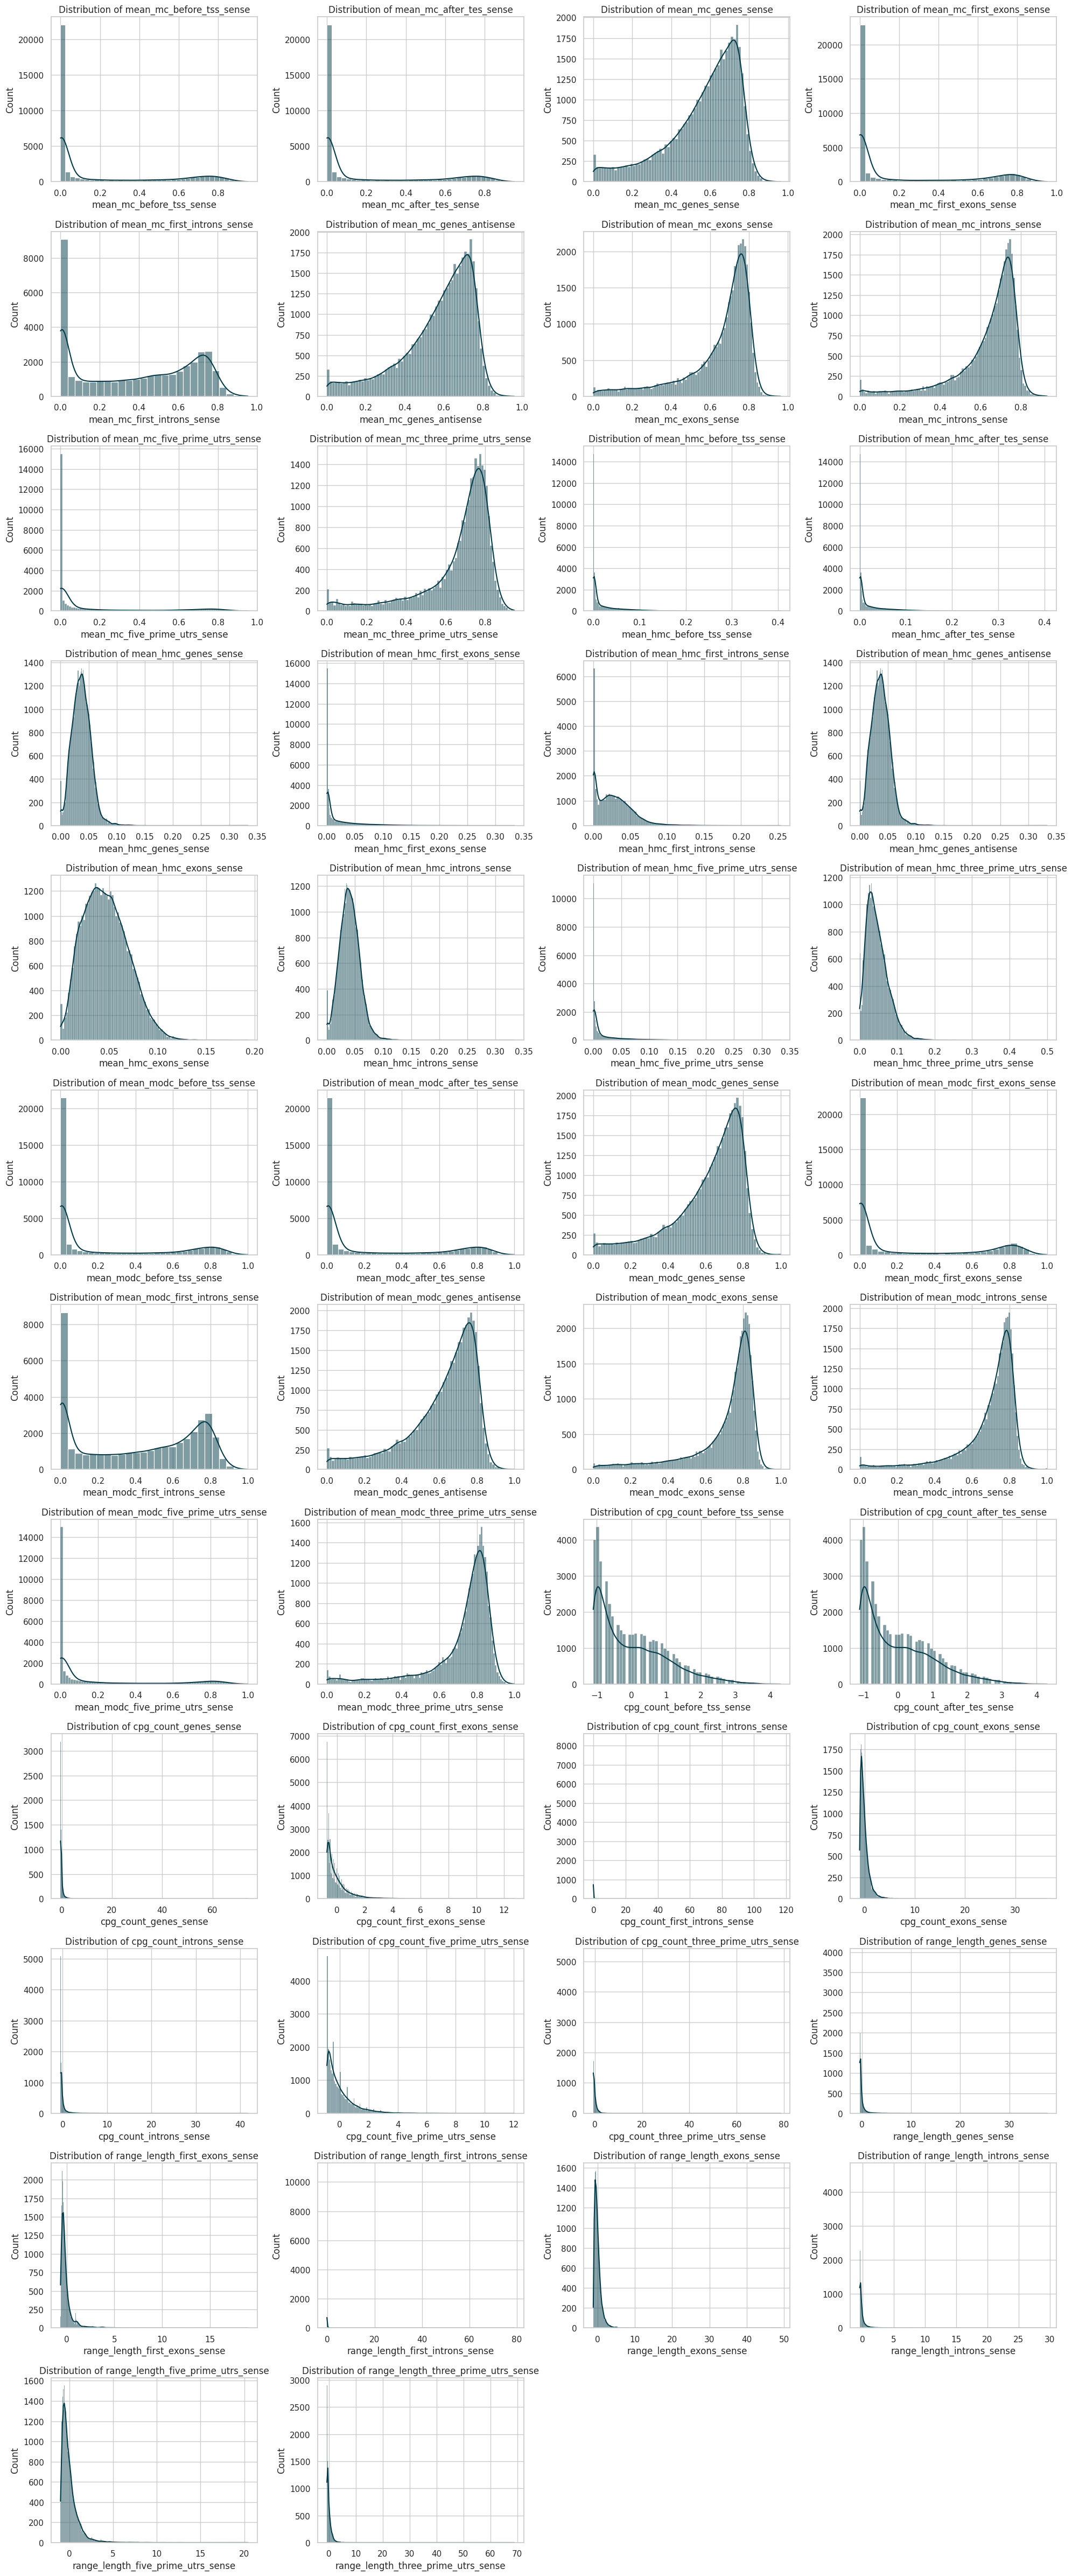

In [112]:
plot_numeric_features_histogram_grid(df_dropped, 'TPM')

In [107]:
extreme_cols_to_drop = [
    "mean_mc_before_tss_sense",
    "mean_hmc_before_tss_sense",
    "mean_modc_before_tss_sense",

    "mean_mc_after_tes_sense",
    "mean_hmc_after_tes_sense",
    "mean_modc_after_tes_sense",

    "mean_mc_first_exons_sense",
    "mean_hmc_first_exons_sense",
    "mean_modc_first_exons_sense",

    "mean_mc_first_introns_sense",
    "mean_hmc_first_introns_sense",
    "mean_modc_first_introns_sense",

    "mean_mc_five_prime_utrs_sense",
    "mean_hmc_five_prime_utrs_sense",
    "mean_modc_five_prime_utrs_sense"
]

In [ ]:
# df_dropped_extreme = df_dropped.drop(extreme_cols_to_drop, axis=1)
# plot_numeric_features_histogram_grid(df_dropped_extreme,"TPM")

number of features: 46


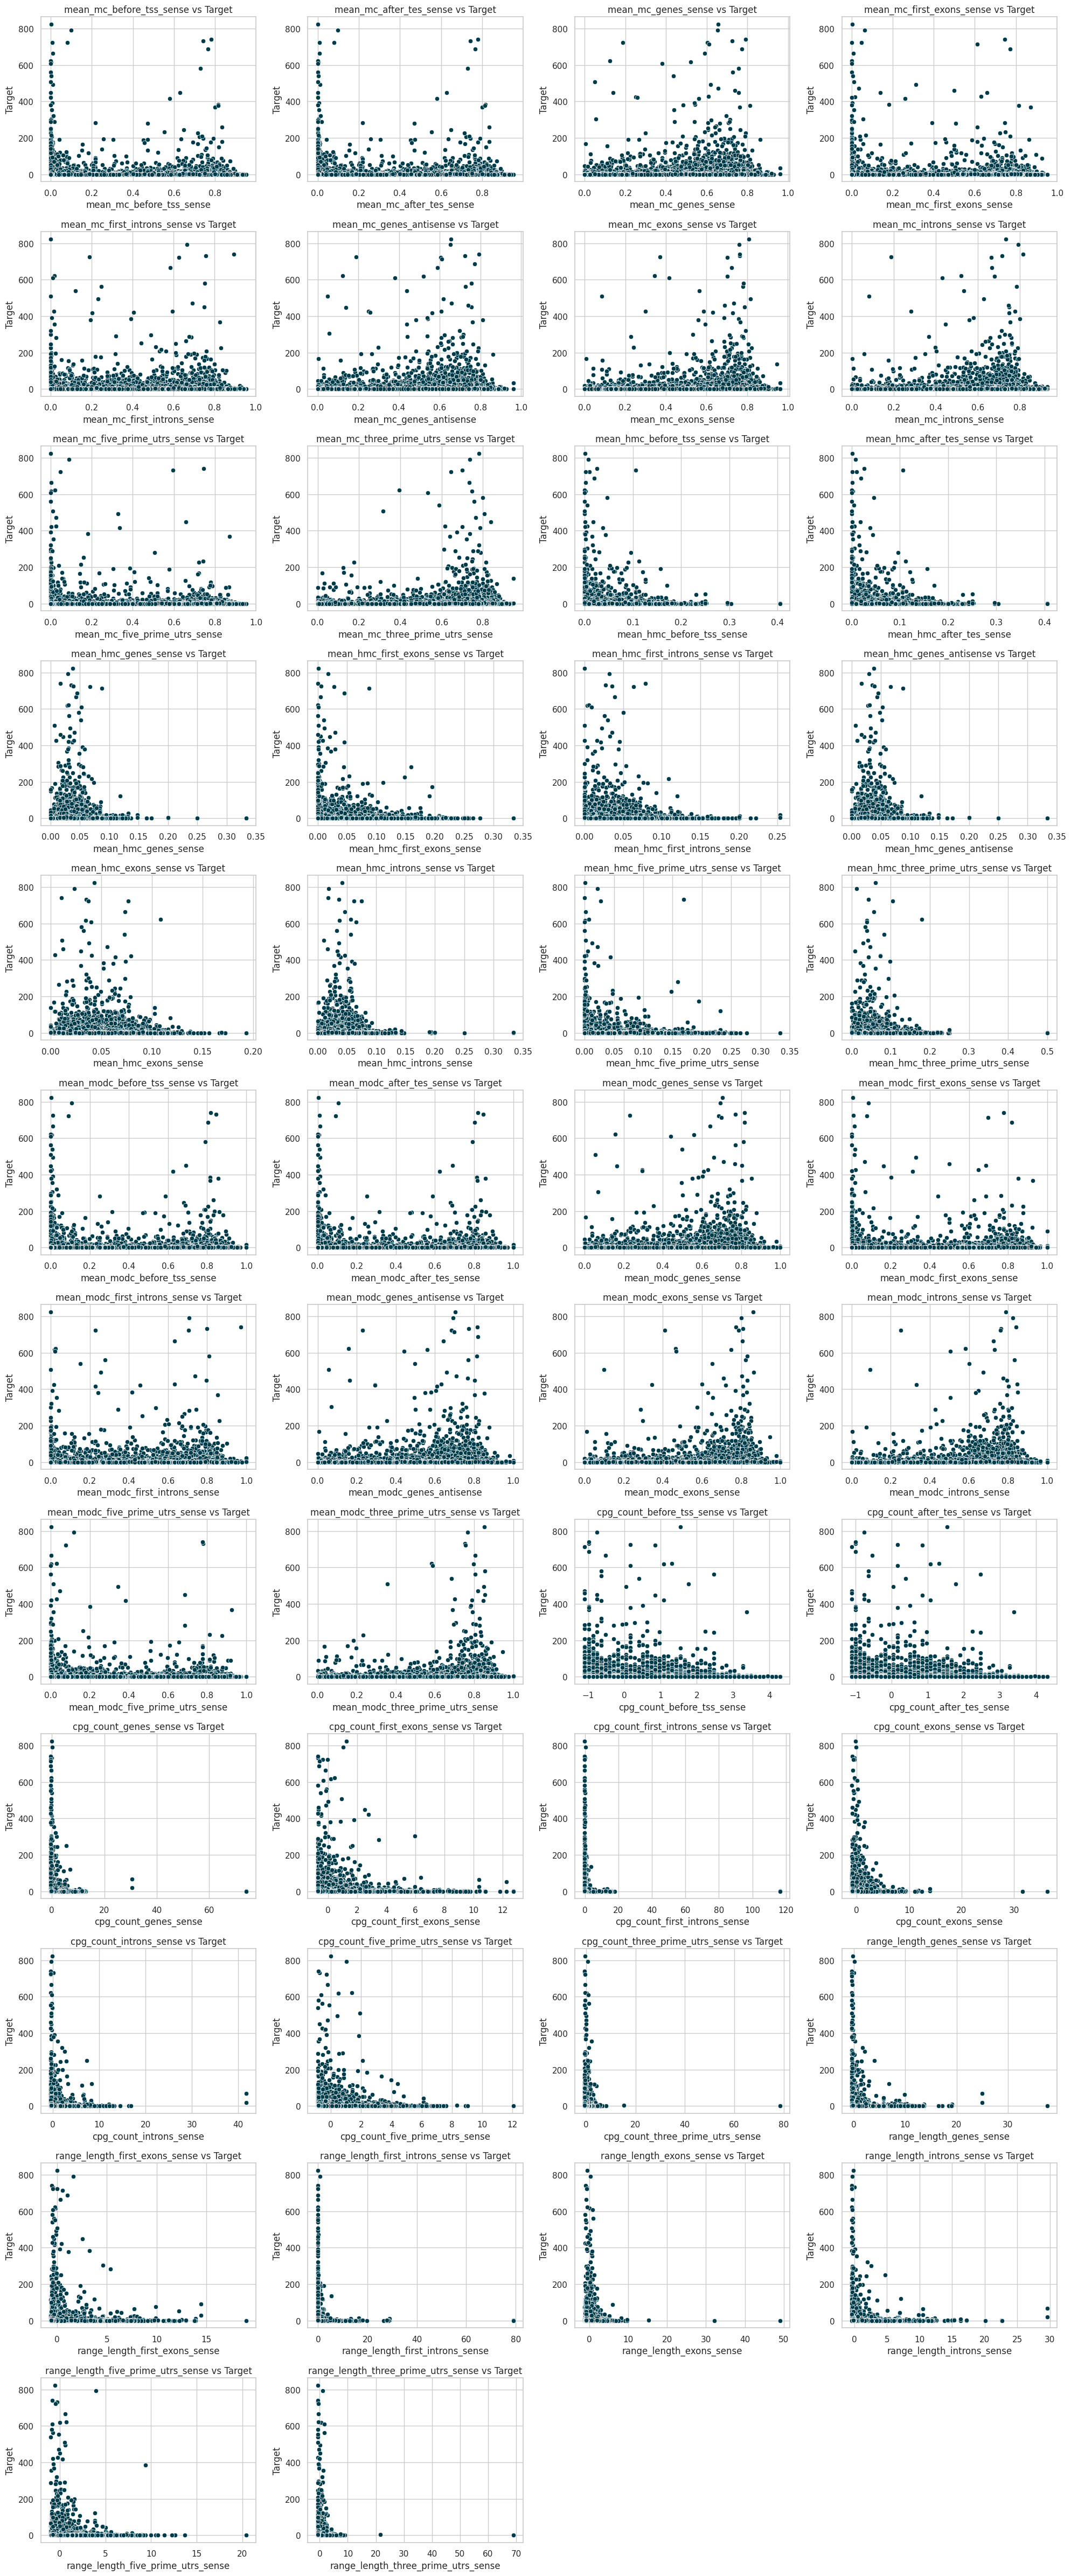

In [109]:
plot_numeric_features_grid(df_dropped,'TPM')

In [48]:
# plot_numeric_features_grid(df,'TPM')

In [113]:
features = [
    c for c in df_clean.columns if
        (c.startswith("mean")
        or c.startswith("cpg_count")
        or c.startswith("range")
        or c.startswith("strand"))
    ]

In [114]:
# df_use = df_clean.copy()
## parse data=df_use[remain_cols], features=remain_cols into prepricess()
# remain_cols = [f for f in df_use.columns if f not in extreme_cols_to_drop]
# remain_feat = [ f for f in features if f not in extreme_cols_to_drop]

X_train, X_test, y_train, y_test = preprocess(
    data=df_clean,
    features=features,
    mod = ["mc", "hmc"],
    target="TPM",
    # test_contig=["8"],
    missing_values_strategy="impute_mean",
    # missing_values_strategy="impute_zero"
)

47
rows with 1.0 mc / hmC mean meth fration: 181
                 Gene_id Chromosome    Start      End Gene_name  strand  \
0  ENSMUSG00000025903.14          1  4807787  4848409    Lypla1       0   
1  ENSMUSG00000025903.14          1  4807787  4848409    Lypla1       0   
2   ENSMUSG00000104217.1          1  4807891  4886769   Gm37988       0   
3   ENSMUSG00000104217.1          1  4807891  4886769   Gm37988       0   
4  ENSMUSG00000033813.15          1  4857813  4897908     Tcea1       0   

   mean_mc_before_tss_sense  mean_mc_after_tes_sense  mean_mc_genes_sense  \
0                  0.000000                 0.000000             0.529368   
1                  0.000000                 0.000000             0.529368   
2                  0.000689                 0.000689             0.472305   
3                  0.000689                 0.000689             0.472305   
4                  0.001969                 0.001969             0.514725   

   mean_mc_first_exons_sense  ...  ra

In [116]:
train_full = pd.concat([X_train, y_train])
test_full = pd.concat([X_test, y_test])

number of features: 46


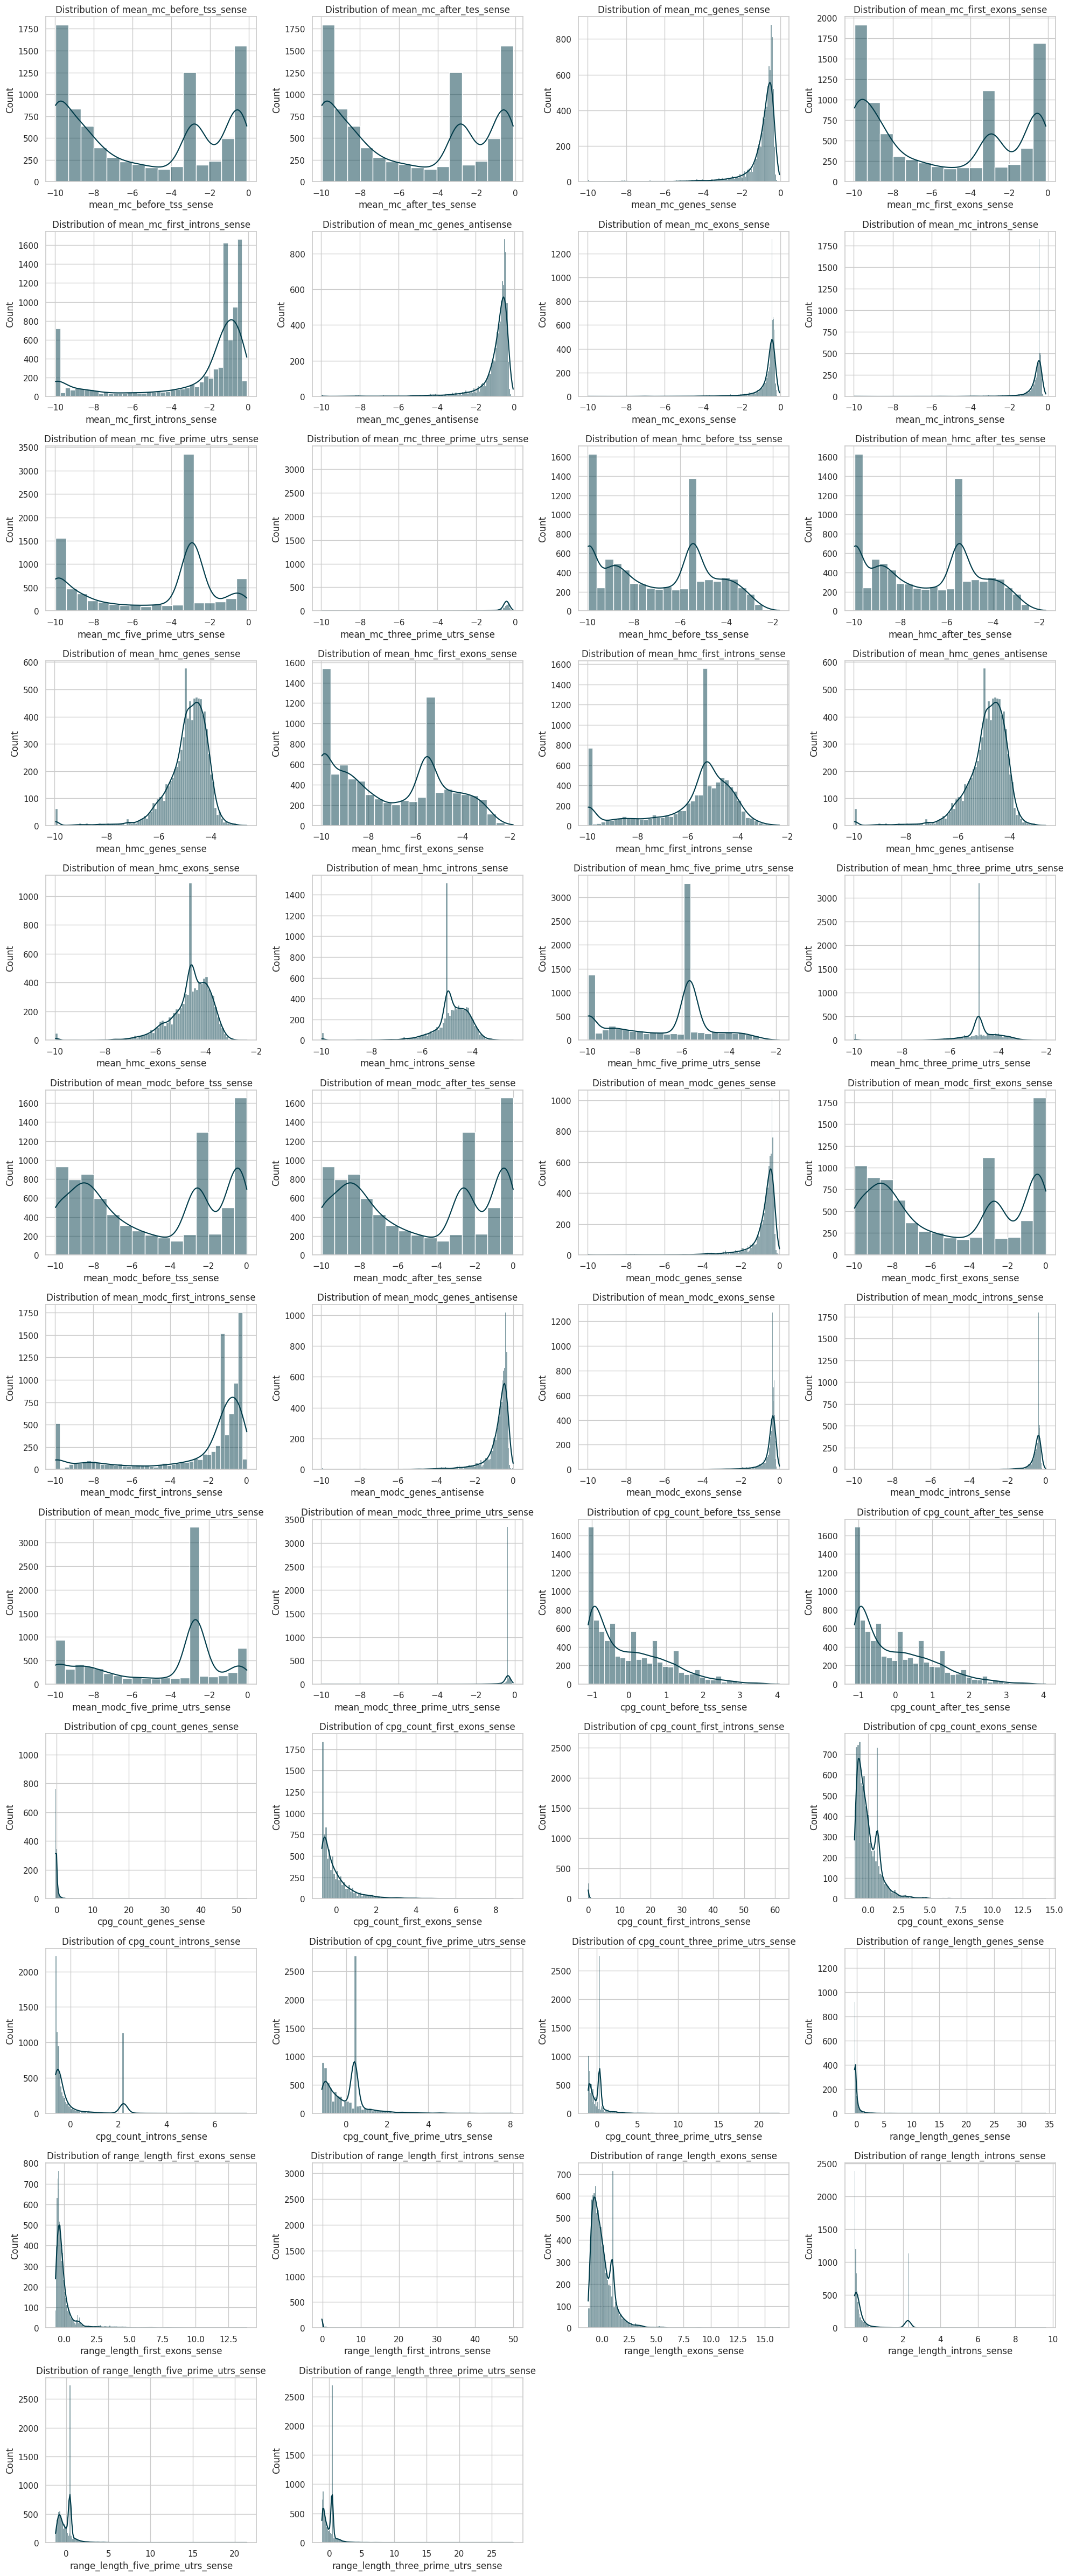

In [117]:
plot_numeric_features_histogram_grid(test_full, 'TPM')


In [53]:
# plot_numeric_features_histogram_grid(train_full, 'TPM')

using all features (code expired):

In [61]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=True,
# )    


USing params
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 600, 'subsample': 0.8}


In [63]:
# df_metrics

mse       rmse       mae        r2  spearman
0  197.719186  14.061265  4.027517 -0.043226  0.028218

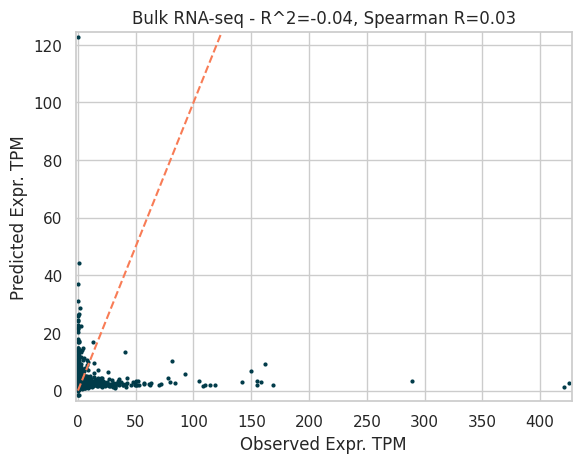

In [64]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

using dropped extreme features

In [51]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=True,
# )    

USing params
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 600, 'subsample': 0.7}


In [52]:
# df_metrics

mse       rmse       mae        r2  spearman
0  309.777767  17.600505  4.612455 -0.043699  0.008379

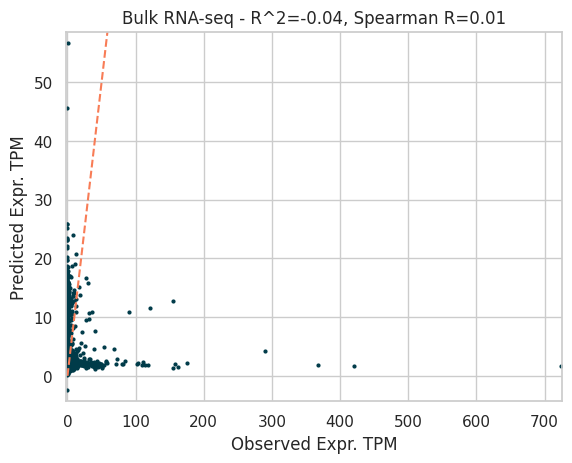

In [53]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

log_transformed data, impute nans with kmeans (n_cluster = 2)

In [128]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=False,
# )  

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}


In [130]:
# df_metrics

mse      rmse       mae        r2  spearman
0  25.37626  5.037485  4.570672 -0.000212  0.032123

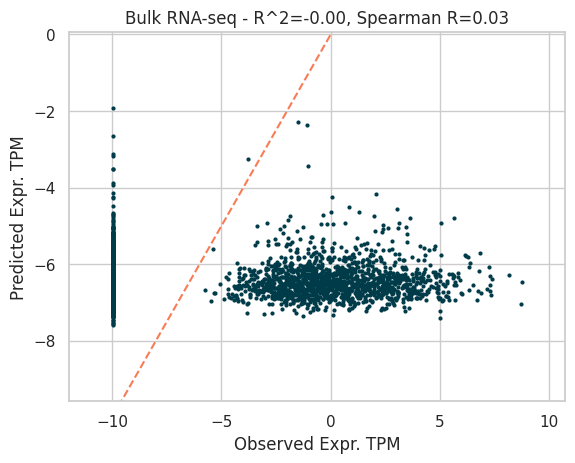

In [129]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

same data and preprocessing as above but running grid search again to seek better performance:

In [118]:
model, df_metrics, y_test, y_pred = run_regressor(
    X_train, X_test, y_train, y_test,
    hyperparameters=default_hyperparameters,
    random_state=0,
    find_optimal_parameters=True,
)  

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}


In [119]:
df_metrics

mse      rmse      mae        r2  spearman
0  25.331433  5.033034  4.57154  0.001554  0.046293

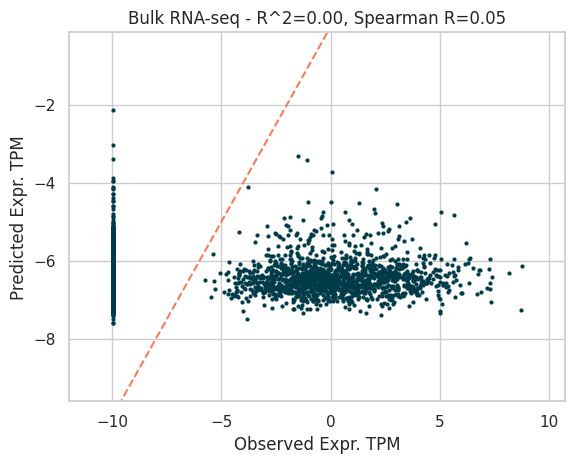

In [120]:
plot_results(
    y_test, 
    y_pred, 
    f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
)

Let's plot the predictions of the models versus the actual data on the held chromosome 8.

In the above model training, we set a pseudo-random state for reproducibility, but we need to ensure our accuracy estimates are robust to alternative starting random states. Below we train the data again with different pseudo-random states, to get an average value for r^2 and Spearman R.

In [ ]:
# df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman"])
# for k in range(0,20):
#     model, df_metrics, _, _ = run_regressor(
#         data=df_features_expression,
#         features=features,
#         mod = ["mc", "hmc"],
#         target="Response",
#         hyperparameters=model_hyperparameters,
#         random_state=k,
#         test_contig=["8"],
#         missing_values_strategy="impute_mean",
#         find_optimal_parameters=False,
#     )
#     df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)
# df_regressor = df_regressor.reset_index(drop=True)

The table below shows the average R^2 and Spearman coefficients of the model:

In [ ]:
# df_regressor[["r2", "spearman"]].describe()

## Binary Classifer

Depending on the biological question you are trying to answer, having a binary classifier may be more than sufficient and you may not need to train a regressor. We can also train such a classifier using [XGBoost](https://xgboost.readthedocs.io/en/stable/). The classifier can be binary (i.e. two categories: high expression and low expression), or have more categories (e.g., we could classify genes as having low expression, moderate expression, or high expression). Having more classes will likely result in a drop in the accuracy of the classifier (since it will have more opportunities to misclassify).

In [121]:
def train_classifier_model(X_train, y_train, hyperparameters, random_state=1):
    """
    Train an XGBoost classifier using the specified hyperparameters
    """
    classifier = xgb.XGBClassifier(
        random_state=random_state,
        **hyperparameters,
    )
    classifier.fit(X_train, y_train)
    return classifier

In [122]:
def evaluate_classifier(model, X_test, y_test):
    """
    Evaluate the performance of the classifier using the test set
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # f1 score
    f1 = f1_score(y_test, y_pred, average="macro")

    # calculate AUC
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")

    return accuracy, f1, auc

In [56]:
def run_classifier_orig(
    data,
    features,
    mod,
    target,
    hyperparameters,
    random_state=1,
    missing_values_strategy="impute_mean",
    test_contig=None,
):
    """
    Run an xgboost classifier
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    classifier = train_classifier_model(X_train, y_train, hyperparameters, random_state)

    accuracy, f1, auc = evaluate_classifier(classifier, X_test, y_test)

    df_metrics = pd.DataFrame(
        {
            "number_of_categories": [len(np.unique(y_train))],
            "accuracy": [accuracy],
            "macro_f1": [f1],
            "auc": [auc],

        }
    )

    return classifier, df_metrics

In [123]:
def run_classifier(
    X_train, X_test, y_train, y_test,
    hyperparameters,
    random_state=1,
):
    """
    Run an xgboost classifier
    """

    # features = select_features(features, mod)
    
    # X_train, X_test, y_train, y_test = split_train_test_data(
    #     data, 
    #     features, 
    #     target, 
    #     test_contig,
    #     missing_values_strategy,
    #     )

    classifier = train_classifier_model(X_train, y_train, hyperparameters, random_state)

    accuracy, f1, auc = evaluate_classifier(classifier, X_test, y_test)

    df_metrics = pd.DataFrame(
        {
            "number_of_categories": [len(np.unique(y_train))],
            "accuracy": [accuracy],
            "macro_f1": [f1],
            "auc": [auc],

        }
    )

    return classifier, df_metrics

Loop over the number of categories and evaluate the metrics of the classifier.

In [57]:
df_dropped_extreme

strand  mean_mc_genes_sense  mean_mc_genes_antisense  \
0           0             0.529368                 0.529368   
1           0             0.529368                 0.529368   
2           0             0.472305                 0.472305   
3           0             0.472305                 0.472305   
4           0             0.514725                 0.514725   
...       ...                  ...                      ...   
43075       1             0.782609                 0.782609   
43078       1             0.642857                 0.642857   
43079       1             0.642857                 0.642857   
43080       1             0.773050                 0.773050   
43081       1             0.773050                 0.773050   

       mean_mc_exons_sense  mean_mc_introns_sense  \
0                 0.708118               0.556417   
1                 0.708118               0.556417   
2                 0.788673               0.479142   
3                 0.788673               0.479142   
4                 0.782642               0.684998   
...                    ...                    ...   
43075                  NaN                    NaN   
43078             0.000000                    NaN   
43079             0.000000                    NaN   
43080             0.867925               0.760894   
43081             0.867925               0.760894   

       mean_mc_three_prime_utrs_sense  mean_hmc_genes_sense  \
0                            0.732611              0.052177   
1                            0.732611              0.052177   
2                                 NaN              0.051780   
3                                 NaN              0.051780   
4                            0.760204              0.049608   
...                               ...                   ...   
43075                             NaN              0.000000   
43078                             NaN              0.071429   
43079                             NaN              0.071429   
43080                        0.846154              0.022290   
43081                        0.846154              0.022290   

       mean_hmc_genes_antisense  mean_hmc_exons_sense  mean_hmc_introns_sense  \
0                      0.052177              0.038949                0.056417   
1                      0.052177              0.038949                0.056417   
2                      0.051780              0.043111                0.054195   
3                      0.051780              0.043111                0.054195   
4                      0.049608              0.019201                0.059372   
...                         ...                   ...                     ...   
43075                  0.000000                   NaN                     NaN   
43078                  0.071429              0.000000                     NaN   
43079                  0.071429              0.000000                     NaN   
43080                  0.022290              0.000000                0.024581   
43081                  0.022290              0.000000                0.024581   

       ...  cpg_count_five_prime_utrs_sense  cpg_count_three_prime_utrs_sense  \
0      ...                        -0.109026                         -0.198780   
1      ...                        -0.109026                         -0.198780   
2      ...                              NaN                               NaN   
3      ...                              NaN                               NaN   
4      ...                        -0.168293                         -0.198780   
...    ...                              ...                               ...   
43075  ...                        -0.820229                         -0.643042   
43078  ...                              NaN                               NaN   
43079  ...                              NaN                               NaN   
43080  ...                        -0.820229                         -0.59

In [126]:
best_params= {'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}

In [127]:
df_classifier = pd.DataFrame(columns=["number_of_categories", "accuracy", "macro_f1", "auc"])

number_of_categories = np.arange(2, 6, 1)
for n in number_of_categories:

    # create n categories based on the response values
    labels = [k for k in range(n)]
    # df_features_expression["category"] = pd.cut(
    #     df_features_expression["Response"], bins=n, labels=labels
    # )
    y_train_binned = pd.cut(
        y_train, bins=n, labels=labels
    )
    y_test_binned = pd.cut(
        y_test, bins=n, labels=labels
    )
    
    # run the classifier
    c, df_metrics = run_classifier(
        X_train, X_test, y_train_binned, y_test_binned,
        # mod=["mc", "hmc"],
        hyperparameters=best_params,
        random_state=1,
    )

    df_classifier = pd.concat([df_classifier, df_metrics], ignore_index=True)

A binary classifier achieves a good accuracy of 80% and AUC of 0.89. As the number of categories increase, the accuracy and F1 score decrease, since the classifier has more opportunities to misclassify. However, with three categories (i.e., low expression, moderate expression, or high expression) we still retain a robust accuracy of 89%. Note that we report the macro-F1 score, where the F1 score is calculated for each class independently, and the unweighted average of these scores is returned.


with all 0 peaked columns dropped

| number_of_categories | accuracy | macro_f1 | auc     |
|----------------------|----------|----------|---------|
| 2                    | 0.999305 | 0.499826 | 0.740625|
| 3                    | 0.999073 | 0.333179 | 0.729542|
| 4                    | 0.998841 | 0.249855 | 0.730702|
| 5                    | 0.997914 | 0.199791 | 0.570156|


using full set of columns applying log transform.

```
best_params= {'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}
```

| number_of_categories | accuracy | macro_f1 | auc     |
|----------------------|----------|----------|---------|
| 2                    | 0.801303 | 0.444846 | 0.536900|
| 3                    | 0.674500 | 0.268538 | 0.521427|
| 4                    | 0.662168 | 0.199188 | 0.511092|
| 5                    | 0.661005 | 0.159182 | 0.511270|


In [128]:
df_classifier

number_of_categories  accuracy  macro_f1       auc
0                    2  0.801303  0.444846  0.536900
1                    3  0.674500  0.268538  0.521427
2                    4  0.662168  0.199188  0.511092
3                    5  0.661005  0.159182  0.511270

## Feature importance

### XGboost feature importance

Let's look at the feature importance of our model, first using XGBoost's own `model.feature_importances_` functionality.

In [129]:
df_features_importance = pd.DataFrame(
    {
        "feature": select_features(features, ["mc", "hmc"]),
        "importance": model.feature_importances_,
    }
)

In [130]:
df_features_importance.sort_values("importance", ascending=False).head(10)

feature  importance
23               mean_modc_genes_sense    0.023042
40            range_length_genes_sense    0.023029
19      mean_hmc_five_prime_utrs_sense    0.022862
26           mean_modc_genes_antisense    0.022766
45  range_length_five_prime_utrs_sense    0.022757
31          cpg_count_before_tss_sense    0.022654
28             mean_modc_introns_sense    0.022445
6              mean_mc_genes_antisense    0.022273
30    mean_modc_three_prime_utrs_sense    0.022191
32           cpg_count_after_tes_sense    0.022055

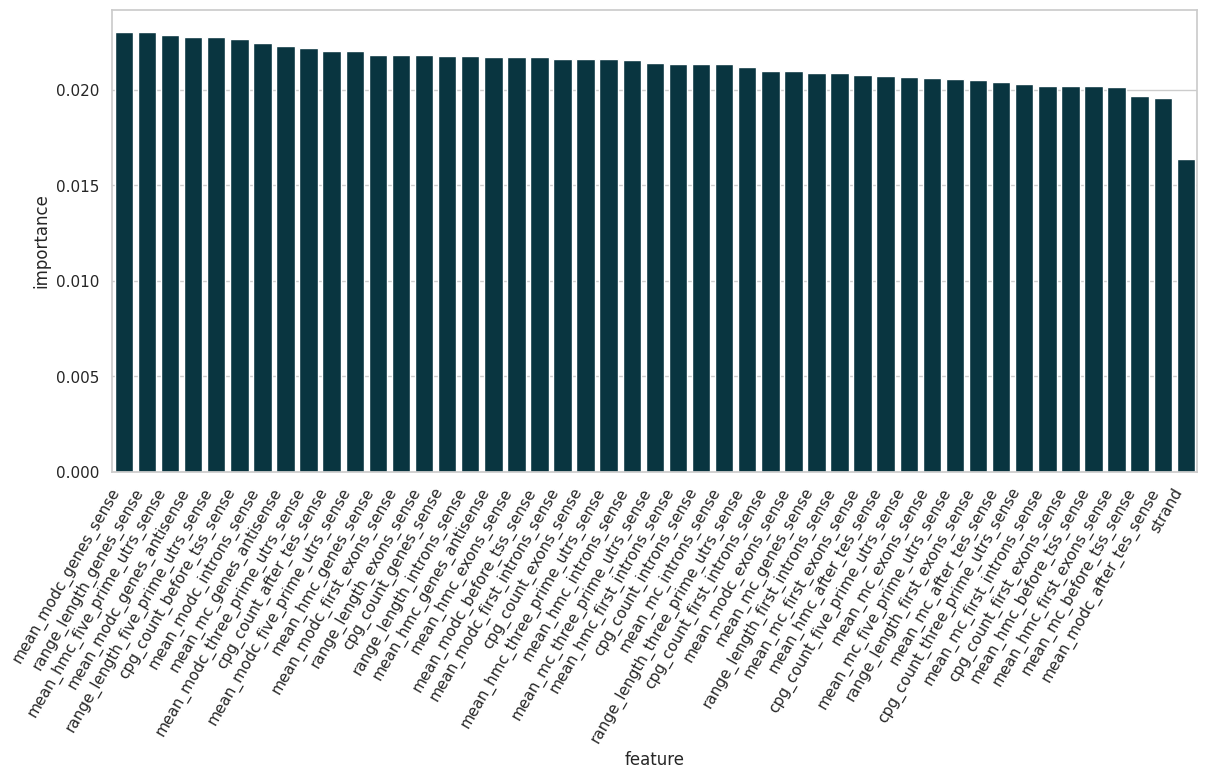

In [131]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    x="feature", 
    y="importance", 
    data=df_features_importance.sort_values("importance", ascending=False),
    )
plt.xticks(rotation=60, ha="right")
plt.show()

The length of the upstream, downstream, and around TSS regions are fixed by the user and therefore play little to no importance in the model. 


### Region importance

Instead of looking at the importance of each feature individually, let's try to get some biological insights on which genomic regions bring the most contribution to the performance of the model. In order to do that, we run our regressor on each regions separately, and record their contributions to the R^2.

In [132]:
column_order

['before_tss',
 'after_tes',
 'five_prime_utrs',
 'first_exons',
 'first_introns',
 'exons',
 'introns',
 'three_prime_utrs',
 'genes']

In [133]:
sense = "sense"

In [137]:
df_clean.columns

Index(['Gene_id', 'Chromosome', 'Start', 'End', 'Gene_name', 'strand',
       'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense',
       'mean_mc_genes_sense', 'mean_mc_first_exons_sense',
       'mean_mc_first_introns_sense', 'mean_mc_genes_antisense',
       'mean_mc_exons_sense', 'mean_mc_introns_sense',
       'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense',
       'mean_hmc_before_tss_sense', 'mean_hmc_after_tes_sense',
       'mean_hmc_genes_sense', 'mean_hmc_first_exons_sense',
       'mean_hmc_first_introns_sense', 'mean_hmc_genes_antisense',
       'mean_hmc_exons_sense', 'mean_hmc_introns_sense',
       'mean_hmc_five_prime_utrs_sense', 'mean_hmc_three_prime_utrs_sense',
       'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense',
       'mean_modc_genes_sense', 'mean_modc_first_exons_sense',
       'mean_modc_first_introns_sense', 'mean_modc_genes_antisense',
       'mean_modc_exons_sense', 'mean_modc_introns_sense',
       'mean_modc_five_prime_utr

In [144]:
N_runs = 10
df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}_{sense}", f"mean_hmc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}","strand"]
    cols_found = [col for col in columns if col in df_clean.columns]
    all_columns = cols_found + ["TPM", "Chromosome"]
    df_one_region = df_clean[all_columns]
    for k in range(0, N_runs):
        X_train, X_test, y_train, y_test = preprocess(
            data=df_one_region,
            features=cols_found,
            mod=["mc", "hmc"],
            target="TPM",
        )
        _, df_metrics, _, _ = run_regressor(
            X_train, X_test, y_train, y_test,
            best_params

        )
        df_metrics["Region"] = region
        df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)

4
rows with 1.0 mc / hmC mean meth fration: 29
   mean_mc_before_tss_sense  mean_hmc_before_tss_sense  \
0                  0.000000                   0.000471   
1                  0.000000                   0.000471   
2                  0.000689                   0.001377   
3                  0.000689                   0.001377   
4                  0.001969                   0.000984   

   cpg_count_before_tss_sense  strand  TPM Chromosome  
0                        27.0       0  0.0          1  
1                        27.0       0  0.0          1  
2                        35.0       0  0.0          1  
3                        35.0       0  0.0          1  
4                        21.0       0  0.0          1  
inside train test split
trainset: (38718, 6)
testset: (4312, 6)
TPM
0.000000     0.065234
0.084900     0.000046
0.357268     0.000046
0.456412     0.000046
0.056211     0.000046
               ...   
25.415845    0.000023
15.213466    0.000023
1.773053     0.000023
4.

Let's see if there are regions where hmC contributes significantly to the performance of the model. In order to visualise this, we repeat the experiment above, this time looking only at region importance for a model with mC but no hmC. 

In [143]:
N_runs = 10
df_regressor_mc_only = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}","strand"]
    cols_found = [col for col in columns if col in df_clean.columns]
    all_columns = cols_found + ["TPM", "Chromosome"]
    df_one_region = df_clean[all_columns]
    for k in range(0, N_runs):
        X_train, X_test, y_train, y_test = preprocess(
            data=df_one_region,
            features=cols_found,
            mod=["mc"],
            target="TPM",
        )
        _, df_metrics, _, _ = run_regressor(
            X_train, X_test, y_train, y_test,
            best_params

        )
        df_metrics["Region"] = region
        df_regressor_mc_only = pd.concat([df_regressor_mc_only, df_metrics], ignore_index=True)

3
rows with 1.0 mc / hmC mean meth fration: 27
   mean_mc_before_tss_sense  cpg_count_before_tss_sense  strand  TPM  \
0                  0.000000                        27.0       0  0.0   
1                  0.000000                        27.0       0  0.0   
2                  0.000689                        35.0       0  0.0   
3                  0.000689                        35.0       0  0.0   
4                  0.001969                        21.0       0  0.0   

  Chromosome  
0          1  
1          1  
2          1  
3          1  
4          1  
inside train test split
trainset: (38720, 5)
testset: (4312, 5)
TPM
0.000000     0.065207
0.084900     0.000046
0.357268     0.000046
0.456412     0.000046
0.056211     0.000046
               ...   
25.415845    0.000023
15.213466    0.000023
1.773053     0.000023
4.024203     0.000023
6.603424     0.000023
Name: count, Length: 1502, dtype: float64
--------------------------------------------------
Chromosome
7     0.100000
2

In [ ]:
# N_runs = 10
# df_regressor_mc_only = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
# for region in column_order:
#     columns = [f"mean_mc_{region}_{sense}", f"mean_hmc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}"]
#     all_columns = columns + ["Response", "Chromosome"]
#     df_one_region = df_features_expression[all_columns]
#     for k in range(0, N_runs):
#         _, df_metrics, _, _ = run_regressor(
#             data=df_one_region,
#             features=columns,
#             mod="mc",
#             target="Response",
#             hyperparameters=model_hyperparameters,
#             random_state=k,
#             test_contig=["8"],
#             missing_values_strategy="impute_mean",
#             find_optimal_parameters=False,
#         )
#         df_metrics["Region"] = region
#         df_regressor_mc_only = pd.concat([df_regressor_mc_only, df_metrics], ignore_index=True)

Let's merge the two expereriments and plot the results.

In [145]:
df_regressor_mc_only["features"] = "mc_only"
df_regressor["features"] = "mc+hmc"
df_regions = pd.concat([df_regressor, df_regressor_mc_only])

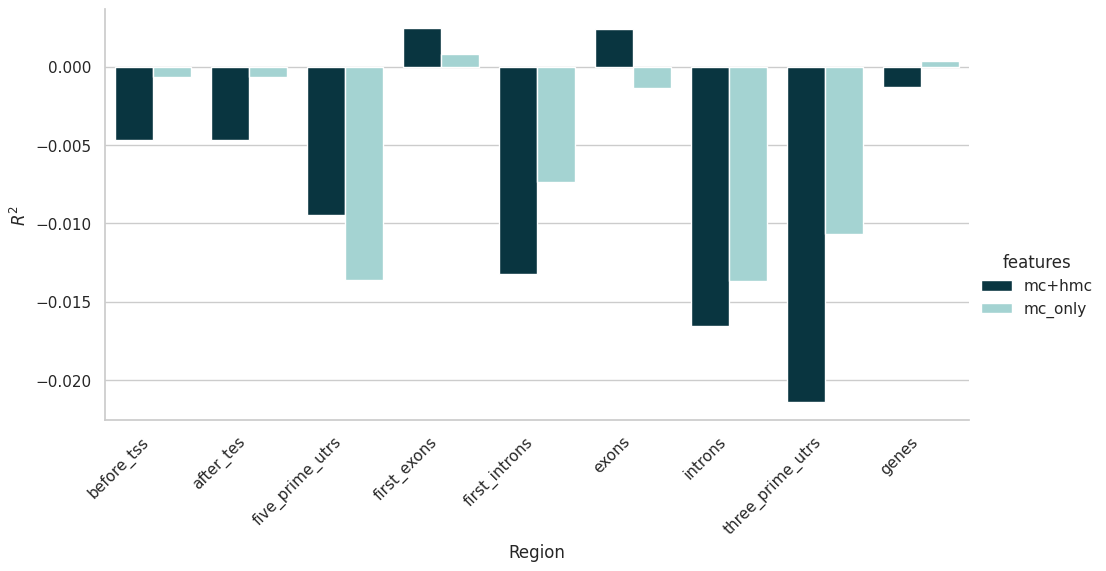

In [146]:
sns.catplot(
    data=df_regions,
    x="Region",
    y="r2",
    hue="features",
    kind="bar",
    palette=biomodal_palette,
    height=5,
    aspect=2,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel(r"$R^2$")
plt.show()

WIP...

In summary, this series of notebooks illustrates how `modality` can help constructing robust machine learning models. It achieves this by condensing methylation data across genomic ranges specified by external annotations, and efficiently grouping them together to generate feature sets, thereby facilitating the model-building process.

This notebook also highlights that the methylation signal obtained from evoC data contains sufficient information to make robust gene expression predictions.